In [20]:
from opt_einsum import contract # idk why but its required to avoid bug in contract with numpy arrays
import torch
import numpy as np
from tqdm.auto import tqdm
torch.set_default_tensor_type(torch.cuda.DoubleTensor)
device=torch.device('cuda:0')
torch.cuda.set_device(device)

/home/wenhan/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [21]:
import importlib
import HOTRG; importlib.reload(HOTRG)
import TNModels; importlib.reload(TNModels)


from HOTRG import HOTRG_layers,forward_observable_tensor,trace_two_tensors,trace_tensor,forward_observalbe_tensor_moments
from TNModels import Models

# scdims

In [22]:
Model=Models['Ising2D']
options={'max_dim':16,'nLayers':30,'gilt_enabled':True,'mcf_enabled':True}
model=Model()
T=model.get_T0()
layers,Ts,logTotals=HOTRG_layers(T,
                            max_dim=options['max_dim'],nLayers=options['nLayers'],
                            options=options)
T=Ts[10]

Generating HOTRG layers


  0%|          | 0/30 [00:00<?, ?it/s]

HOTRG layers generated


In [228]:
from scipy.sparse.linalg import LinearOperator,eigs
def wrap_pytorch(func):
    return lambda v:func(torch.tensor(v)).detach().cpu().numpy()

def wrap_pbar(pbar):
    return lambda func: lambda *args, **kwargs: (func(*args, **kwargs), pbar.update(1))[0]

def get_transfer_matrix(T,n=2):
    bond_dim=T.shape[0]
    bond_dim1=T.shape[2]
    pbar=tqdm()
    @wrap_pbar(pbar)
    @wrap_pytorch
    def matvec(v):
        #     1 2 3
        #(-3)-T-|-|-(-4)
        #     [ v ] 
        v=contract('ij,...->ij...',torch.eye(bond_dim1),v.reshape((bond_dim,)*n))
        for i in range(n):
            idx1=[-3,-5]+list(-2 if j==i else j for j in range(n))
            idx2=[-1,-2,-5,-4]
            idx3=[-3,-4]+list(-1 if j==i else j for j in range(n))
            v=contract(v,idx1,T,idx2,idx3)
        return contract('ii...->...',v).flatten()
    @wrap_pbar(pbar)
    @wrap_pytorch
    def rmatvec(v):
        v=contract('ij,...->ij...',torch.eye(bond_dim1),v.reshape((bond_dim,)*n))
        for i in range(n):
            idx1=[-3,-5]+list(-1 if j==i else j for j in range(n))
            idx2=[-1,-2,-5,-4]
            idx3=[-3,-4]+list(-2 if j==i else j for j in range(n))
            v=contract(v,idx1,T.conj(),idx2,idx3)
        return contract('ii...->...',v).flatten()
    return LinearOperator(shape=(bond_dim**n,bond_dim**n),matvec=matvec,rmatvec=rmatvec)

def get_scdims(T,n=2,k=10,output_vectors=True):
    M=get_transfer_matrix(T,n)
    s,u=eigs(M,k=k)
    u,s=torch.tensor(u),torch.tensor(s)
    s,u=s.abs()[s.abs().argsort(descending=True)],u[:,s.abs().argsort(descending=True)]
    scaling=np.exp(2*np.pi/n)
    scdims=torch.log(s/s[0]).abs()/torch.log(torch.as_tensor(scaling))
    eigvecs=u.T
    if output_vectors:
        return scdims,eigvecs
    else:
        return scdims
    
get_scdims(T,n=2,k=10)[0]

0it [00:00, ?it/s]

tensor([0.0000, 0.1251, 1.0055, 1.1312, 1.1316, 2.0172, 2.0200, 2.0207, 2.0265,
        2.1469])

# scan binder

In [28]:
len(model.get_observable_moments('magnetization',n=4))

2

In [29]:
Model=Models['Ising2D']
options={'max_dim':16,'nLayers':30,'gilt_enabled':False,'mcf_enabled':True}

data=[]
for dbeta in tqdm(np.linspace(-1e-3,1e-3,11)):
    params=Model.get_default_params()
    params['beta']+=dbeta
    model=Model(params)
    T=model.get_T0()
    layers,Ts,logTotals=HOTRG_layers(T,
                            max_dim=options['max_dim'],nLayers=options['nLayers'],
                            options=options)

    T_op0_moments,checkerboard=model.get_observable_moments('magnetization',n=4)
    T_op_momentss,logTotals=forward_observalbe_tensor_moments(T_op0_moments,layers,checkerboard=checkerboard,return_layers=True,cached_Ts=Ts)

    for iLayer in range(len(Ts)):
        logTotal=logTotals[iLayer]
        T=T_op_momentss[iLayer][0]
        T_op=T_op_momentss[iLayer][1]
        T_op2=T_op_momentss[iLayer][2]
        T_op3=T_op_momentss[iLayer][3]
        T_op4=T_op_momentss[iLayer][4]

        logZ=(logTotal+trace_tensor(T).log())/2**iLayer
        magnetization=(trace_two_tensors(T_op)/trace_two_tensors(T)).abs().sqrt()
        moment2=trace_tensor(T_op2)/trace_tensor(T)
        moment4=trace_tensor(T_op4)/trace_tensor(T)

        data.append({
            'beta':params['beta'],
            'iLayer':iLayer,
            'logZ':logZ.item(),
            'magnetization':magnetization.item(),
            'moment2':moment2.item(),
            'moment4':moment4.item(),
            })

  0%|          | 0/11 [00:00<?, ?it/s]

Generating HOTRG layers


  0%|          | 0/30 [00:00<?, ?it/s]

HOTRG layers generated


  0%|          | 0/30 [00:00<?, ?it/s]

Generating HOTRG layers


  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

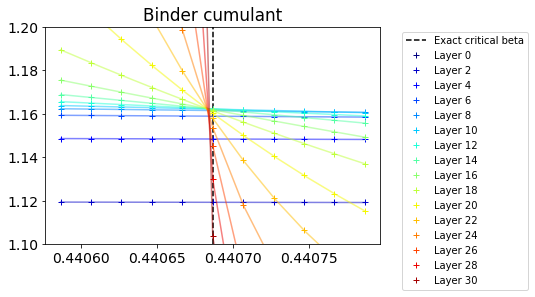

In [176]:
import pandas as pd
import matplotlib.pyplot as plt
from IsingSolutions import ising2d as ising2d_exact
from scipy.interpolate import interp1d
df=pd.DataFrame(data)

df['binder']=df['moment4']/df['moment2']**2

exact_critical_beta=ising2d_exact.critical_beta
nLayers=df['iLayer'].max()+1
iLayers=np.arange(0,nLayers,2)
beta_min,beta_max=df['beta'].min(),df['beta'].max()
betas=np.linspace(beta_min,beta_max,1000)
cm=plt.get_cmap('jet')

plt.rcParams.update({'font.size': 14,'legend.fontsize':10})

plt.figure(figsize=(6,4))
plt.title('Binder cumulant')
plt.axvline(exact_critical_beta,color='k',linestyle='--',label='Exact critical beta')
for iLayer in iLayers:
    df1=df[df['iLayer']==iLayer]
    plt.plot(df1['beta'],df1['binder'],'+',label='Layer %d'%iLayer,color=cm(iLayer/nLayers))
    f1=interp1d(df1['beta'],df1['binder'],kind='linear')
    plt.plot(betas,f1(betas),color=cm(iLayer/nLayers,alpha=.5))
plt.ylim(1.1,1.2)
plt.legend(ncol=1, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# plt.figure(figsize=(6,4))
# plt.title('Magnetization')
# plt.axvline(exact_critical_beta,color='k',linestyle='--',label='Exact critical beta')
# for iLayer in iLayers:
#     df1=df[df['iLayer']==iLayer]
#     plt.plot(df1['beta'],df1['magnetization'],'+',label='Layer %d'%iLayer,color=cm(iLayer/nLayers))
#     f1=interp1d(df1['beta'],df1['magnetization'],kind='linear')
#     plt.plot(betas,f1(betas),color=cm(iLayer/nLayers,alpha=.5))
# plt.legend(ncol=1, bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()


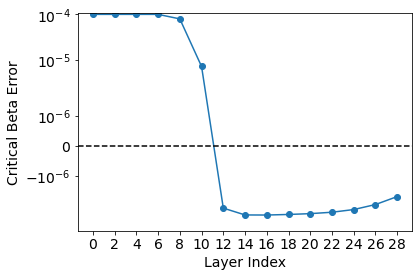

In [177]:
# for layer i and i+1, find the crossing point of the binder
# plot i vs crossing point
# find the crossing point by spline fitting

from scipy.optimize import minimize,root
from scipy.interpolate import interp1d
from matplotlib.scale import SymmetricalLogScale

crossings=[]
beta_min,beta_max=df['beta'].min(),df['beta'].max()
betas_interp=np.linspace(beta_min,beta_max,1000)

for iLayer in range(0, nLayers-1, 2):
    df1 = df[df['iLayer'] == iLayer]
    df2 = df[df['iLayer'] == iLayer+2]

    f1 = interp1d(df1['beta'], df1['binder'], kind='linear')
    f2 = interp1d(df2['beta'], df2['binder'], kind='linear')
    
    crossing=minimize(lambda x: (f1(x)-f2(x))**2, (beta_min+beta_max)/2, bounds=[(beta_min,beta_max)]).x[0]

    # Append the crossing point to the list of crossings
    crossings.append(crossing)

# Plot the crossing points vs. layer index
plt.plot(range(0, nLayers-1, 2), (crossings-exact_critical_beta), 'o-')
plt.axhline(0, color='k', linestyle='--')
plt.yscale(SymmetricalLogScale(axis='y',base=10, linthresh=np.min(np.abs(crossings-exact_critical_beta))))
plt.xticks(range(0, nLayers-1, 2))
plt.xlabel('Layer Index')
plt.ylabel('Critical Beta Error')
plt.show()